## Praktium 5

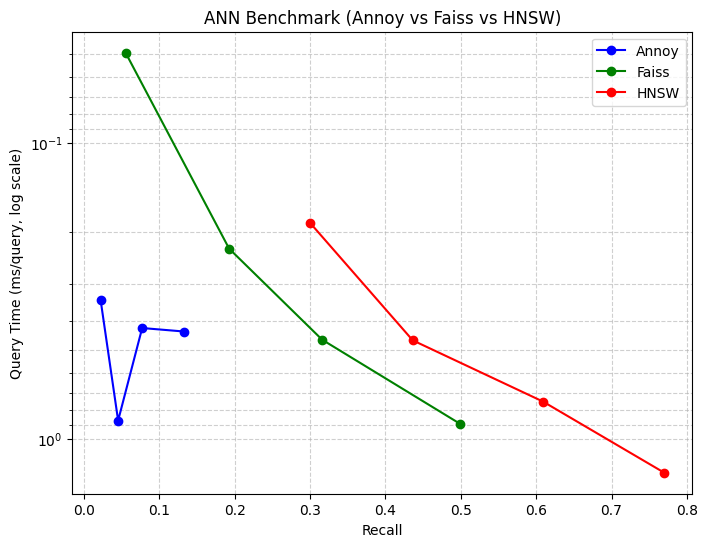

In [ ]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()